# Import Packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ovm.monetary.model import MonetaryModel

import logging
import os
import random
import typing as tp

import line_profiler
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib notebook
# %matplotlib widget
from mesa.datacollection import DataCollector
from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization.modules import ChartModule
import numpy as np
import pandas as pd
import chart_studio.plotly as py
import plotly.express as px
import plotly.graph_objs as go
import seaborn as sns
from tqdm import tqdm

from ovm.monetary.agents import (
    MonetaryAgent, 
    MonetaryArbitrageur, 
    MonetaryKeeper, 
    MonetaryLiquidator, 
    MonetarySniper
)

from ovm.monetary.markets import MonetaryFMarket
from ovm.monetary.model import MonetaryModel
from ovm.monetary.options import DataCollectionOptions
from ovm.monetary.plot_labels import (
    price_deviation_label,
    spot_price_label,
    futures_price_label,
    skew_label,
    inventory_wealth_ovl_label,
    inventory_wealth_usd_label,
    GINI_LABEL,
    GINI_ARBITRAGEURS_LABEL,
    SUPPLY_LABEL,
    TREASURY_LABEL,
    LIQUIDITY_LABEL, 
)

from ovm.monetary.plots import (
    DEFAULT_FIGURE_SIZE, 
    convert_time_interval_in_seconds_to_indices, 
    construct_full_time_axis, 
    construct_time_axis, 
    get_indices_and_time_axis_to_plot, 
    plot_multiple_variables_over_time, 
    plot_price_deviations, 
    plot_skews, 
    plot_single_variable_over_time, 
    plot_supply, 
    plot_treasury, 
    plot_liquidity, 
    plot_spot_vs_futures_price
)

from ovm.monetary.reporters import * 
from ovm.monetary.data_io import (
    construct_sims_map, 
    construct_ticker_to_series_of_prices_map_from_simulated_prices
)

from ovm.paths import (
    HistoricalDataSource, 
    construct_historical_data_directory
)

from ovm.simulation.bootstrap import plot_multivariate_simulation
from ovm.simulation.resampling import (
    load_log_returns,
    simulate_new_price_series_via_bootstrap,
    store_simulated_price_series_in_output_directory
)

from ovm.tickers import (
    ETH_USD_TICKER,
    COMP_USD_TICKER,
    LINK_USD_TICKER,
    YFI_USD_TICKER
)

from ovm.time_resolution import (
    TimeResolution, 
    TimeScale
)

In [3]:
logger = logging.getLogger(__name__)
logger.level

0

In [4]:
logging.getLevelName(logging.root.level)

'WARNING'

In [5]:
logging.root.level

30

In [6]:
%load_ext line_profiler

# Set Parameters

In [7]:
time_resolution = TimeResolution.FIFTEEN_SECONDS

# 200000 steps corresponds to about 1.14 months
# 200000 * 15 / 60 / 60 / 24 / 365.25 * 12 = 1.14077116131
# number_of_steps_to_simulate = 200000

# number_of_steps_to_simulate = 1000

# 700000 steps corresponds to about 4 months (i.e. 1/3 year with 15 seconds per step)
# 700000 * 15 / 60 / 60 / 24 / 365.25 = 0.33272492204
# number_of_steps_to_simulate = 700000

# number_of_steps_to_simulate = int(24 * 60 * 60 / time_resolution.in_seconds)

# run agent based simulations for 2 years
number_of_steps_to_simulate = int(2 * 365.25 * 24 * 60 * 60 / time_resolution.in_seconds)
print(f'number_of_steps_to_simulate={number_of_steps_to_simulate}')

directory_path = \
    construct_historical_data_directory(
        historical_data_source=HistoricalDataSource.FTX, 
        time_resolution=time_resolution)

numpy_seed = 42

tickers = [ETH_USD_TICKER,
           # not a long history of simulation (can we use a different token instead)
           COMP_USD_TICKER,
           # not a long history of simulation (can we use a different token instead)
           LINK_USD_TICKER,
           # less than half a year of simulation (can we use a different token instead)
           YFI_USD_TICKER
           ]

ovl_usd_replacement_ticker = 'YFI-USD'
ovl_usd_ticker = 'OVL-USD'

tickers_with_ovl = [ovl_usd_ticker if ticker == ovl_usd_replacement_ticker else ticker for ticker in tickers]
tickers_with_ovl

number_of_steps_to_simulate=4207680


['ETH-USD', 'COMP-USD', 'LINK-USD', 'OVL-USD']

# Load Historical Price Data and Resample

In [8]:
log_return_df, closing_price_df, initial_prices = \
    load_log_returns(series_names=tickers,
                     period_length_in_seconds=time_resolution.in_seconds,
                     directory_path=directory_path)
log_return_df.shape

(705007, 4)

In [9]:
simulated_sample_length_in_seconds = \
    5 * 365.25 * 24 * 60 * 60

# simulated_sample_length_in_seconds = log_return_df.shape[0] * time_resolution.in_seconds
np.random.seed(numpy_seed)

simulated_prices = \
    simulate_new_price_series_via_bootstrap(
        initial_prices=initial_prices,
        input_log_return_df=log_return_df,
        time_resolution=time_resolution,
        block_length_in_seconds=4 * 24 * 60 * 60,  # 4 day block length
        simulated_sample_length_in_steps_in_seconds=simulated_sample_length_in_seconds,
            number_of_paths=1)
simulated_prices.shape

(1, 10519200, 4)

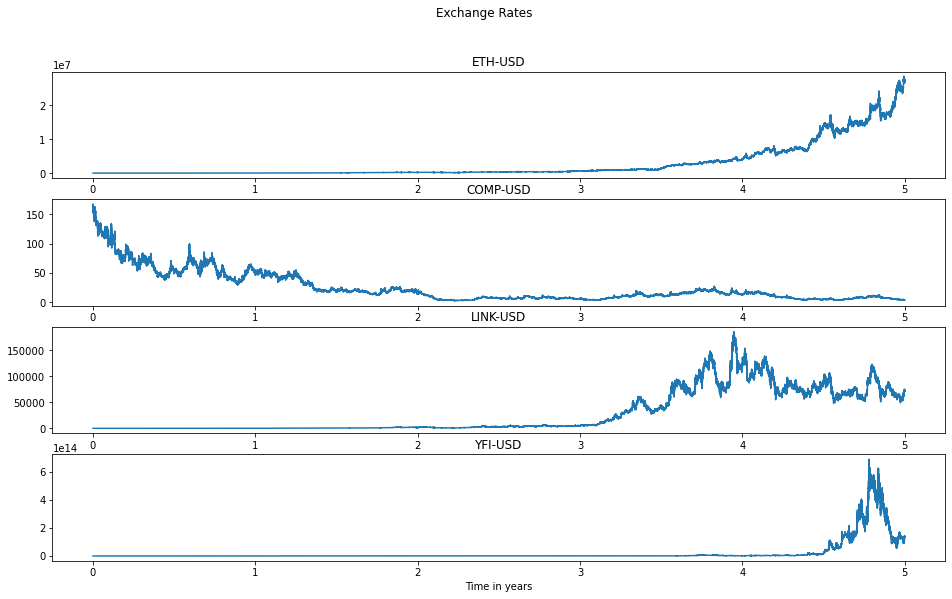

In [10]:
plot_multivariate_simulation(simulated_data=simulated_prices,
                             series_names=tickers, 
                             time_resolution=time_resolution, 
                             title='Exchange Rates')

In [11]:
ticker_to_time_series_of_prices_map = \
    construct_ticker_to_series_of_prices_map_from_simulated_prices(simulated_prices=simulated_prices, 
                                                                   tickers=tickers_with_ovl)

# Load Resampled Data

# Construct Agent Based Monetary Model

In [16]:
# TIME_RESOLUTION = TimeResolution.FIFTEEN_SECONDS
# DATA_SIM_RNG = 42

# Constants
STEPS_MONTH = int((86400*30)/time_resolution.in_seconds)

total_supply = 100000  # OVL
base_wealth = 0.0002*100000  # OVL
base_market_fee = 0.0030
base_max_leverage = 10.0
base_liquidate_reward = 0.1
base_maintenance = 0.6
liquidity = 0.285*total_supply
time_liquidity_mine = STEPS_MONTH
treasury = 0.0
sampling_interval = 240


# For the first 30 days, emit until reach 100% of total supply; ONLY USE IN LIQUDITIY FOR NOW JUST AS TEST!
liquidity_supply_emission = [(0.51*total_supply/time_liquidity_mine)*i + 0.285*total_supply
                             for i
                             in range(time_liquidity_mine)]

# num_arbitrageurs = min(int(total_supply*0.1/base_wealth), 100)
num_arbitrageurs = min(int(total_supply*0.1/base_wealth), 50)
num_keepers = int(total_supply*0.005/base_wealth)
# num_traders = int(total_supply*0.005/base_wealth)
num_traders = 0
# num_holders = int(total_supply*0.5/base_wealth)
num_holders = 0
# num_snipers = min(int(total_supply*0.1/base_wealth), 100)
num_snipers = min(int(total_supply*0.1/base_wealth), 50)
# num_liquidators = int(total_supply*0.005/base_wealth)
num_liquidators = 2 * (len(tickers) + 1)
num_agents = num_arbitrageurs + num_keepers + \
    num_traders + num_holders + num_snipers + num_liquidators

DATA_COLLECTOR_NAME = 'data_collector'
data_collection_options = \
    DataCollectionOptions(compute_gini_coefficient=False,
                          compute_wealth=False,
                          compute_inventory_wealth=False)

monetary_model = \
    MonetaryModel(num_arbitrageurs=num_arbitrageurs, 
                  num_keepers=num_keepers, 
                  num_traders=num_traders, 
                  num_holders=num_holders, 
                  num_snipers=num_snipers, 
                  num_liquidators=num_liquidators, 
                  base_maintenance=base_maintenance, 
                  base_liquidate_reward=base_liquidate_reward, 
                  sims=ticker_to_time_series_of_prices_map, 
                  base_wealth=base_wealth, 
                  base_market_fee=base_market_fee, 
                  base_max_leverage=base_max_leverage, 
                  liquidity=liquidity, 
                  liquidity_supply_emission=liquidity_supply_emission, 
                  treasury=treasury, 
                  sampling_interval=sampling_interval, 
                  data_collection_options=data_collection_options, 
                  seed=0)

print("Model kwargs for initial conditions of sim:")
print(f"num_arbitrageurs = {num_arbitrageurs}")
print(f"num_snipers = {num_snipers}")
print(f"num_keepers = {num_keepers}")
print(f"num_traders = {num_traders}")
print(f"num_holders = {num_holders}")
print(f"num_liquidators = {num_liquidators}")
print(f"total number of agents = {num_agents}")
print(f"base_wealth = {base_wealth}")

Model kwargs for initial conditions of sim:
num_arbitrageurs = 50
num_snipers = 50
num_keepers = 25
num_traders = 0
num_holders = 0
num_liquidators = 10
total number of agents = 135
base_wealth = 20.0


Drastically reduced the number of traders and holders to bring down the memory requirement for storing agent wealth (with the original numbers it would have been 7500 agents total). This would exceed the 128GB mem of my machine with 200000 steps

# Run Simulation

In [17]:
def run_model(number_of_steps_to_simulate: int):
    for i in tqdm(range(number_of_steps_to_simulate + 1)):
        monetary_model.step()

In [18]:
number_of_steps_to_simulate

4207680

In [19]:
run_model(number_of_steps_to_simulate)

  0%|          | 8403/4207681 [00:14<1:47:59, 648.11it/s]/home/michael/PycharmProjects/overlay-monetary/ovm/monetary/agents.py:136: RuntimeWarning: invalid value encountered in double_scalars
  open_leverage = open_position_notional/value
/home/michael/PycharmProjects/overlay-monetary/ovm/monetary/markets.py:551: RuntimeWarning: invalid value encountered in double_scalars
  open_leverage = open_position_notional/value
 23%|██▎       | 968488/4207681 [3:14:50<10:51:40, 82.84it/s] 


KeyboardInterrupt: 

In [20]:
for market_name, market in monetary_model.fmarkets.items():
    print(f'open positions on {market_name} = {len(market.positions)}')

open positions on ETH-USD = 50276
open positions on COMP-USD = 72332
open positions on LINK-USD = 57175
open positions on OVL-USD = 75546


# Extract Model Variables

In [21]:
model_vars_df = monetary_model.data_collector.get_model_vars_dataframe()
model_vars_df.head()

,d-ETH-USD,d-COMP-USD,d-LINK-USD,d-OVL-USD,s-ETH-USD,s-COMP-USD,s-LINK-USD,s-OVL-USD,f-ETH-USD,f-COMP-USD,...,Skew COMP-USD,Skew LINK-USD,Skew OVL-USD,Number of Open Positions on ETH-USD,Number of Open Positions on COMP-USD,Number of Open Positions on LINK-USD,Number of Open Positions on OVL-USD,Supply,Treasury,Liquidity
0,0.000000,0.0,1.153482e-16,0.0,284.500432,157.1,7.699974,3565.0,284.500432,157.1,...,0.0,0.0,0.0,0,0,0,0,31200.0,0.0,28500.0
1,0.000000,0.0,1.153482e-16,0.0,284.500432,157.1,7.699974,3565.0,284.500432,157.1,...,0.0,0.0,0.0,0,0,0,0,31200.0,0.0,28500.0
2,-0.000596,0.0,-6.026242e-04,0.0,284.670019,157.1,7.704617,3565.0,284.500432,157.1,...,0.0,0.0,0.0,0,0,0,0,31200.0,0.0,28500.0
3,-0.000229,0.0,-8.763042e-04,0.0,284.565658,157.1,7.706728,3565.0,284.500432,157.1,...,0.0,0.0,0.0,0,0,0,0,31200.0,0.0,28500.0
4,-0.000092,0.0,-3.496026e-03,0.0,284.526523,157.1,7.726988,3565.0,284.500432,157.1,...,0.0,0.0,0.0,0,0,0,0,31200.0,0.0,28500.0


In [22]:
model_vars_df.to_parquet('model_vars.parq')

In [23]:
model_vars_df.memory_usage(deep=True)

Index                                       128
d-ETH-USD                               7747920
d-COMP-USD                              7747920
d-LINK-USD                              7747920
d-OVL-USD                               7747920
s-ETH-USD                               7747920
s-COMP-USD                              7747920
s-LINK-USD                              7747920
s-OVL-USD                               7747920
f-ETH-USD                               7747920
f-COMP-USD                              7747920
f-LINK-USD                              7747920
f-OVL-USD                               7747920
Skew ETH-USD                            7747920
Skew COMP-USD                           7747920
Skew LINK-USD                           7747920
Skew OVL-USD                            7747920
Number of Open Positions on ETH-USD     7747920
Number of Open Positions on COMP-USD    7747920
Number of Open Positions on LINK-USD    7747920
Number of Open Positions on OVL-USD     

In [24]:
model_vars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 968490 entries, 0 to 968489
Data columns (total 23 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   d-ETH-USD                             968490 non-null  float64
 1   d-COMP-USD                            968490 non-null  float64
 2   d-LINK-USD                            968490 non-null  float64
 3   d-OVL-USD                             968490 non-null  float64
 4   s-ETH-USD                             968490 non-null  float64
 5   s-COMP-USD                            968490 non-null  float64
 6   s-LINK-USD                            968490 non-null  float64
 7   s-OVL-USD                             968490 non-null  float64
 8   f-ETH-USD                             968490 non-null  float64
 9   f-COMP-USD                            968490 non-null  float64
 10  f-LINK-USD                            968490 non-null  float64
 11  

In [25]:
# fig = px.line(model_vars_df, y="Supply", title='OVL Supply')
# fig = px.line(model_vars_df, y="Treasury", title='Treasury')
# fig.show()


# Extract Wealth

In [26]:
def convert_time_in_seconds_to_index(
    time_resolution: TimeResolution, 
    time_in_seconds: float):
    return int(np.floor(time_in_seconds / time_resolution.in_seconds))

In [27]:
quarter_year_index = \
    convert_time_in_seconds_to_index(
        time_resolution=time_resolution, 
        time_in_seconds=365.25 / 4.0 * 24 * 60 * 60)
quarter_year_index

525960

In [28]:
one_year_index = \
    convert_time_in_seconds_to_index(
        time_resolution=time_resolution, 
        time_in_seconds=365.25 * 24 * 60 * 60)
one_year_index

2103840

In [29]:
one_day_index = \
    convert_time_in_seconds_to_index(
        time_resolution=time_resolution, 
        time_in_seconds=24 * 60 * 60)
one_day_index

5760

In [30]:
525960 / monetary_model.schedule.steps

0.5430733266700258

In [31]:
monetary_model.schedule.steps / 4 / 60 / 24

168.14027777777778

In [32]:
type(monetary_model.data_collector._agent_records)

dict

In [33]:
def extract_agent_vars_for_time_step(monetary_model: MonetaryModel, time_step: int):
    agent_vars_for_time_step = \
        monetary_model.data_collector._agent_records[time_step]
    column_names = ['time_step', 'agent_id'] + list(monetary_model.data_collector.agent_reporters.keys())
    
    return pd.DataFrame(data=agent_vars_for_time_step, columns=column_names)

In [34]:
column_names = ['time_step', 'agent_id'] + list(monetary_model.data_collector.agent_reporters.keys())
column_names

['time_step', 'agent_id', 'Wealth']

In [35]:
monetary_model.data_collector.agent_reporters

{'Wealth': functools.partial(<function DataCollector._getattr at 0x7fbd8599b790>, 'wealth')}

In [36]:
df = \
    extract_agent_vars_for_time_step(monetary_model, quarter_year_index)
df.to_csv(f'agent_wealth_after_{quarter_year_index}_time_steps.csv')

In [37]:
monetary_model.data_collector._agent_records[quarter_year_index]

[(525960, 0, 2.4817624413990966),
 (525960, 1, 0.3662575509104378),
 (525960, 2, 0.11102866137834067),
 (525960, 3, 3.3988790983250596),
 (525960, 4, -4.069199671412376e-108),
 (525960, 5, -1e-323),
 (525960, 6, -1e-323),
 (525960, 7, 24.77275907238091),
 (525960, 8, -3.2453520391912724e-270),
 (525960, 9, 2.5035500614562842),
 (525960, 10, 0.3284781211750417),
 (525960, 11, 20.491630981094573),
 (525960, 12, 0.34709646254263504),
 (525960, 13, 0.001615830710068762),
 (525960, 14, -5.819403547908138e-237),
 (525960, 15, -1e-323),
 (525960, 16, 45.854873595941676),
 (525960, 17, -1.3305e-320),
 (525960, 18, 2.0783348183038073),
 (525960, 19, 21.833185483075535),
 (525960, 20, 0.23308095006330032),
 (525960, 21, 0.005533350309465568),
 (525960, 22, 3.1243858254340706),
 (525960, 23, -1e-323),
 (525960, 24, -5.63049685385798e-309),
 (525960, 25, -1e-323),
 (525960, 26, -1e-323),
 (525960, 27, 29.689275666091508),
 (525960, 28, 0.5188870603393442),
 (525960, 29, 0.05611480437561686),
 (525

# Extract Agent Variables

In [38]:
# monetary_model.data_collector.__dict__

In [39]:
agent_vars_df = monetary_model.data_collector.get_agent_vars_dataframe()
print(len(agent_vars_df))

130746015


In [40]:
# agent_vars_df.to_csv(f'agent_vars.csv')

In [41]:
agent_vars_df.to_parquet(f'agent_vars.parq')

In [42]:
agent_vars_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 130746015 entries, (0, 0) to (968488, 134)
Data columns (total 1 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Wealth  float64
dtypes: float64(1)
memory usage: 1.7 GB


In [43]:
agent_vars_df.tail(300)

Wealth
Step   AgentID           
968486 105      19.958000
       106      19.952000
       107      19.784000
       108      19.988002
       109      19.988000
...                   ...
968488 130      23.497556
       131      28.197686
       132      25.396418
       133      22.957356
       134      23.776674

[300 rows x 1 columns]

In [44]:
# agent_vars_df.loc[(699999, 1), :]
# df.loc[('cobra', 'mark i'), 'shield']

In [45]:
# agent_wealth = agent_vars_df.loc[pd.IndexSlice[one_year_index, :], :].values
agent_wealth = agent_vars_df.loc[pd.IndexSlice[one_day_index, :], :].values

In [46]:
agent_wealth.shape

(135, 1)

In [47]:
agent_wealth.sum()

2698.3105481214798

In [48]:
def arbitrageur_indices():
    return 0, num_arbitrageurs


def keeper_indices():
    return num_arbitrageurs, num_arbitrageurs+num_keepers


def sniper_indices():
    begin_index = num_arbitrageurs + num_keepers + num_holders + num_traders
    end_index = num_arbitrageurs + num_keepers + num_holders + num_traders + num_snipers
    return begin_index, end_index

In [49]:
sorted(agent_wealth[sniper_indices()[0]:sniper_indices()[1]])

[array([19.13087171]),
 array([19.46742814]),
 array([19.76]),
 array([19.784]),
 array([19.784]),
 array([19.784]),
 array([19.856]),
 array([19.856]),
 array([19.874]),
 array([19.88]),
 array([19.904]),
 array([19.904]),
 array([19.904]),
 array([19.928]),
 array([19.928]),
 array([19.928]),
 array([19.9280486]),
 array([19.92810073]),
 array([19.94]),
 array([19.95205037]),
 array([19.958]),
 array([19.958]),
 array([19.964]),
 array([19.964]),
 array([19.964]),
 array([19.97]),
 array([19.976]),
 array([19.976]),
 array([19.976]),
 array([19.976]),
 array([19.976]),
 array([19.982]),
 array([19.982]),
 array([19.9820036]),
 array([19.988]),
 array([19.988]),
 array([19.9880018]),
 array([20.]),
 array([20.]),
 array([20.]),
 array([20.]),
 array([20.]),
 array([20.]),
 array([20.]),
 array([20.]),
 array([20.]),
 array([20.]),
 array([20.]),
 array([20.]),
 array([20.])]

In [50]:
sorted(agent_wealth[keeper_indices()[0]:keeper_indices()[1]])

[array([20.]),
 array([20.]),
 array([20.]),
 array([20.]),
 array([20.]),
 array([20.]),
 array([20.]),
 array([20.]),
 array([20.]),
 array([20.]),
 array([20.]),
 array([20.]),
 array([20.]),
 array([20.]),
 array([20.]),
 array([20.]),
 array([20.]),
 array([20.]),
 array([20.]),
 array([20.]),
 array([20.]),
 array([20.]),
 array([20.]),
 array([20.]),
 array([20.])]

In [51]:
sorted(agent_wealth[arbitrageur_indices()[0]:arbitrageur_indices()[1]])

[array([10.59190592]),
 array([15.08019033]),
 array([17.91712791]),
 array([18.18993248]),
 array([18.49694327]),
 array([18.63179562]),
 array([19.24904447]),
 array([19.36128832]),
 array([19.40548174]),
 array([19.50328672]),
 array([19.63514976]),
 array([19.67475675]),
 array([19.8084608]),
 array([19.82053946]),
 array([19.82757722]),
 array([19.8514333]),
 array([19.88018]),
 array([19.892]),
 array([19.904]),
 array([19.916]),
 array([19.94]),
 array([19.952]),
 array([19.9520288]),
 array([19.98667899]),
 array([20.]),
 array([20.]),
 array([20.]),
 array([20.]),
 array([20.]),
 array([20.]),
 array([20.]),
 array([20.00758779]),
 array([20.02610108]),
 array([20.06308884]),
 array([20.12698335]),
 array([20.1502206]),
 array([20.24397933]),
 array([20.42353932]),
 array([20.4502822]),
 array([20.48191356]),
 array([20.50022554]),
 array([20.68604881]),
 array([20.80475774]),
 array([21.20520555]),
 array([21.63192617]),
 array([21.89496393]),
 array([22.49401478]),
 array([2

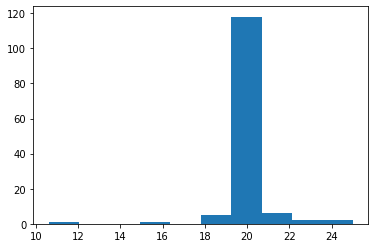

In [52]:
histogram = plt.hist(agent_vars_df.loc[pd.IndexSlice[one_day_index, :], :].values)

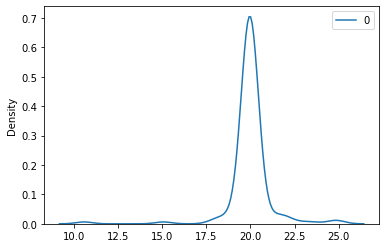

In [53]:
sns.kdeplot(data=agent_wealth);

# Plot Results

## New Plots with 100 Arbitrageurs and 100 Snipers (no traders and no holders)

In [54]:
plot_time_scale = TimeScale.YEARS

### Set Plot Horizon in Seconds

In [55]:
plot_begin_years = 0.0
# plot_end_years = 5 * 365.25 * 24 * 60 * 60  # 5 years
# plot_end_years = 0.75 * 365.25 * 24 * 60 * 60  # 9 months
plot_end_years = 1 * 365.25 * 24 * 60 * 60  # 1 year
time_interval_to_plot_in_seconds = (plot_begin_years, plot_end_years)
time_interval_to_plot_in_seconds = None

### OVL Supply

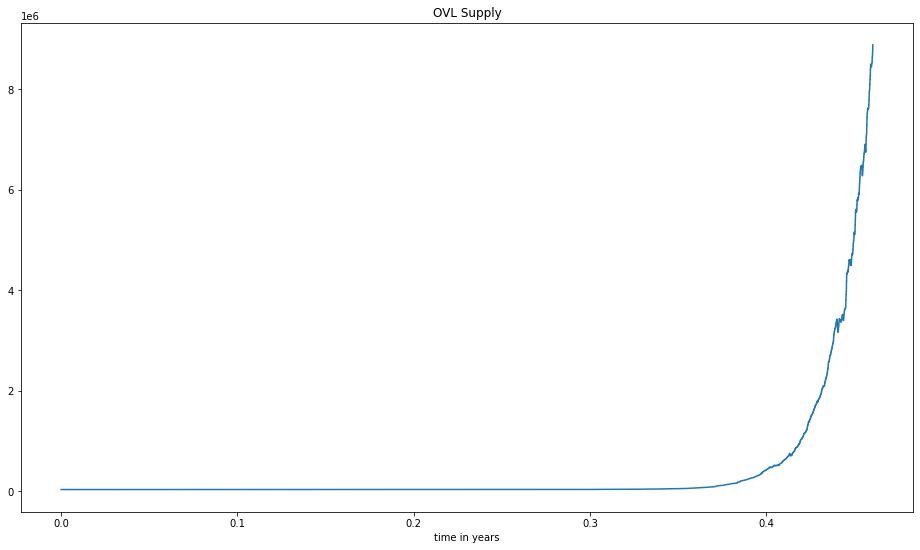

In [71]:
plot_supply(model_vars_df=model_vars_df, 
            plot_time_scale=plot_time_scale, 
            time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
            time_resolution=time_resolution, 
            data_interval=data_collection_options.data_collection_interval)

### Liquidity

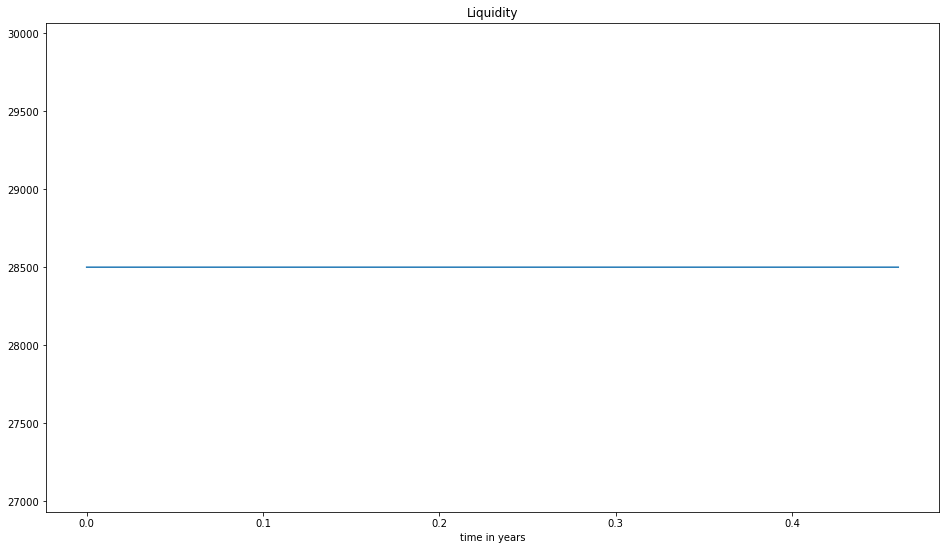

In [70]:
plot_liquidity(model_vars_df=model_vars_df,  
               plot_time_scale=plot_time_scale, 
               time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
               time_resolution=time_resolution, 
               data_interval=data_collection_options.data_collection_interval)

### Treasury

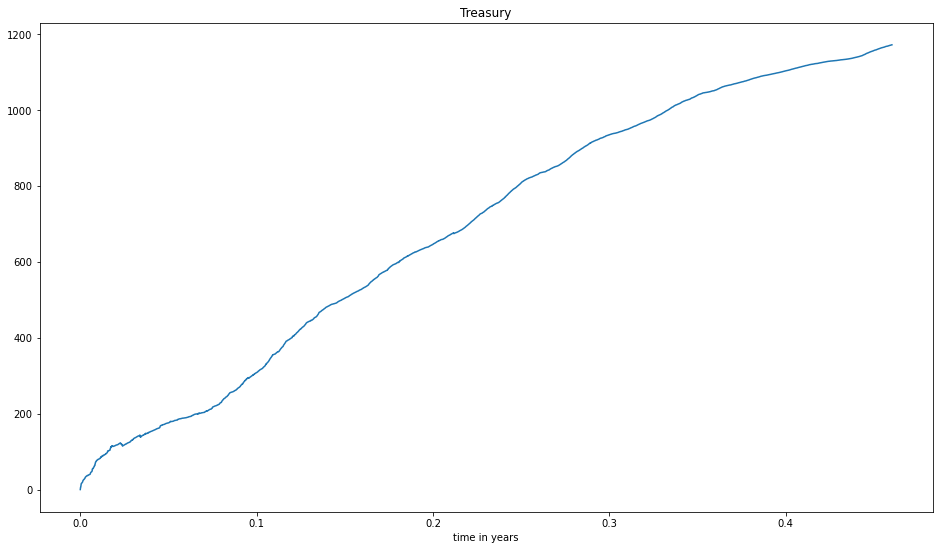

In [67]:
plot_treasury(model_vars_df=model_vars_df, 
              plot_time_scale=plot_time_scale, 
              time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
              time_resolution=time_resolution, 
              data_interval=data_collection_options.data_collection_interval)

### Price Deviations

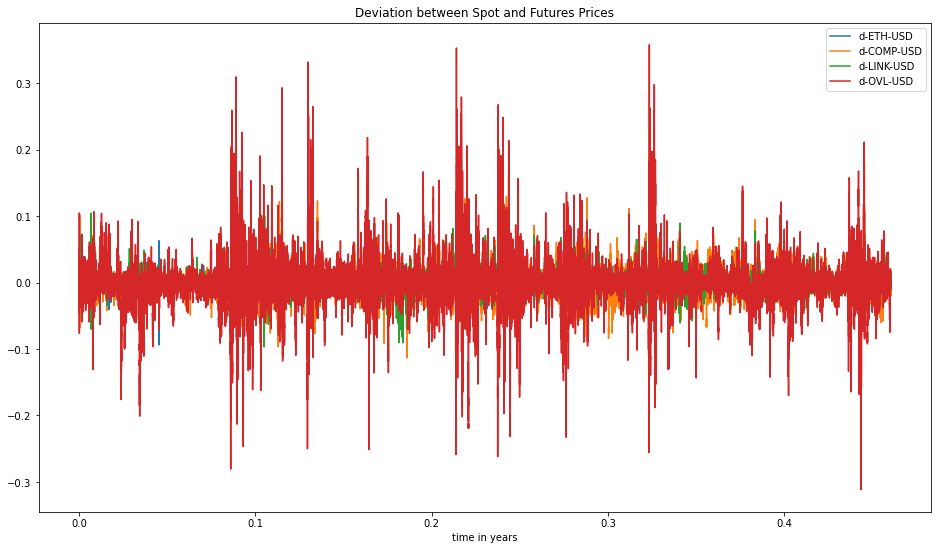

In [59]:
plot_price_deviations(
    model_vars_df=model_vars_df, 
    tickers=tickers_with_ovl, 
    plot_time_scale=plot_time_scale, 
    time_resolution=time_resolution, 
    time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
    data_interval=data_collection_options.data_collection_interval)

### Skew

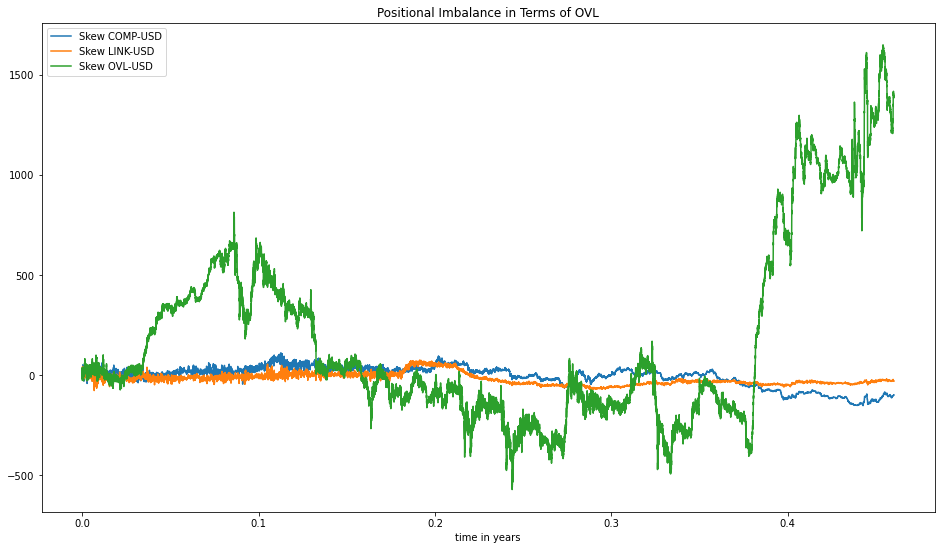

In [72]:
plot_skews(
    model_vars_df=model_vars_df, 
    tickers=tickers_with_ovl[1:], 
    plot_time_scale=plot_time_scale, 
    time_resolution=time_resolution, 
    time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
    data_interval=data_collection_options.data_collection_interval)

#### Correlation between Skew and Futures Price

In [61]:
for i, ticker in enumerate(tickers_with_ovl):
    if i > 0:
        break
    skew = model_vars_df.loc[:, skew_label(ticker)].values
    futures_price = model_vars_df.loc[:, futures_price_label(ticker)].values
    spot_price = model_vars_df.loc[:, spot_price_label(ticker)].values
    print(np.corrcoef(skew, futures_price))
    print(np.corrcoef(skew, spot_price))

[[ 1.         -0.41297245]
 [-0.41297245  1.        ]]
[[ 1.         -0.41348563]
 [-0.41348563  1.        ]]


### Spot vs. Futures Prices

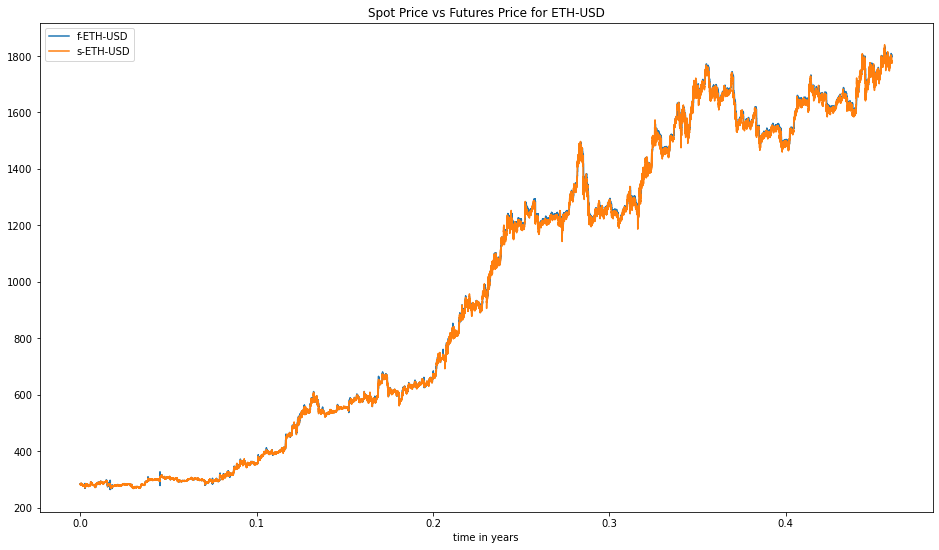

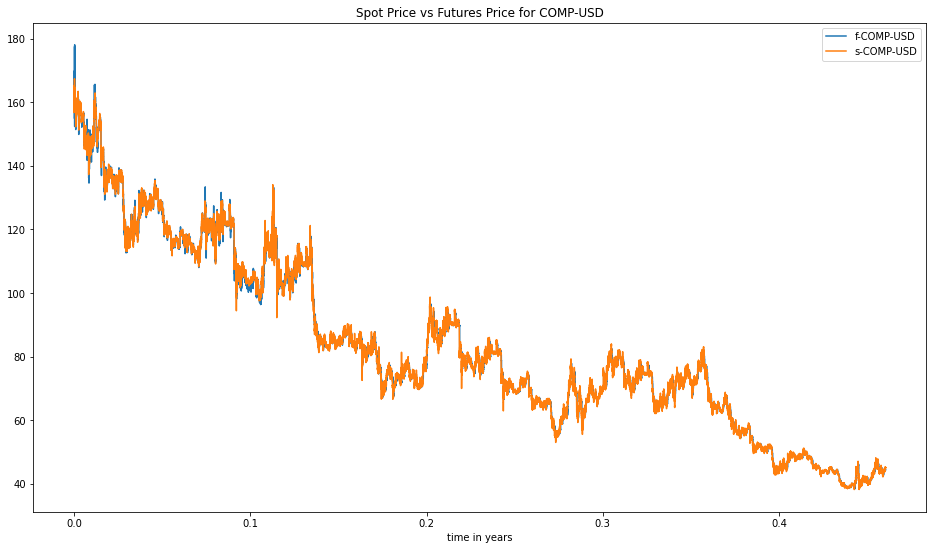

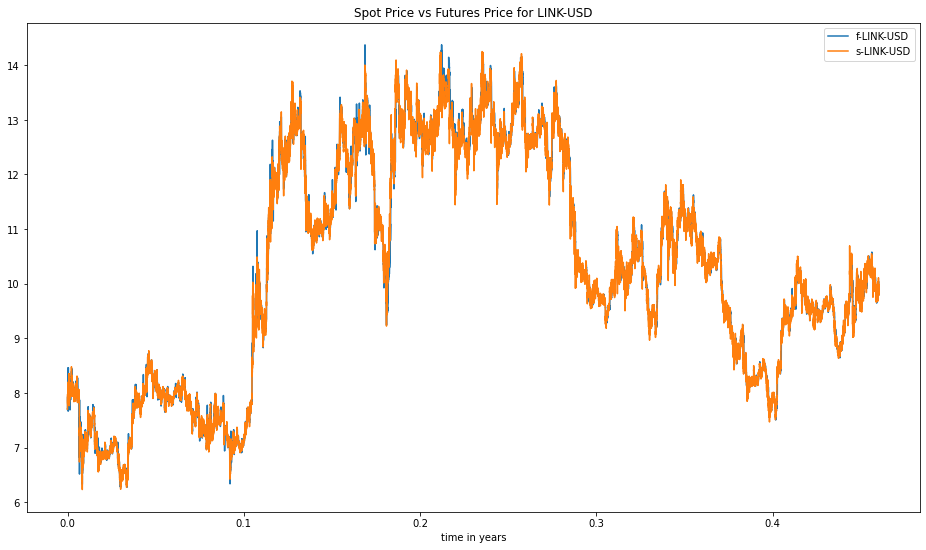

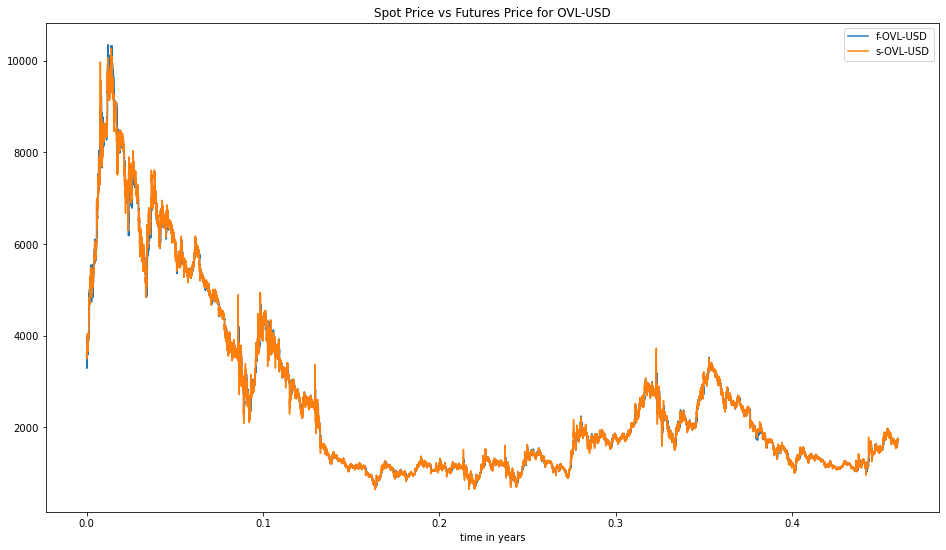

In [62]:
for i, ticker in enumerate(tickers_with_ovl):
    plot_spot_vs_futures_price(
        model_vars_df=model_vars_df, 
        ticker=ticker, 
        plot_time_scale=plot_time_scale, 
        time_resolution=time_resolution, 
        time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
        data_interval=data_collection_options.data_collection_interval)

In [63]:
# %lprun \
#     -f compute_gini \
#     -f compute_price_difference \
#     -f compute_futures_price \
#     -f compute_spot_price \
#     -f compute_supply \
#     -f compute_liquidity \
#     -f compute_treasury \
#     -f compute_wealth_for_agent_type \
#     -f compute_inventory_wealth_for_agent \
#     -f compute_inventory_wealth_for_agent_type \
#     -f compute_positional_imbalance_by_market \
#     -f DataCollector.collect \
#     -f MonetaryAgent.step \
#     -f MonetaryArbitrageur._unwind_positions \
#     -f MonetaryArbitrageur._unwind_next_position \
#     -f MonetaryArbitrageur.trade \
#     -f MonetaryArbitrageur.step \
#     -f MonetaryKeeper.step \
#     -f MonetaryKeeper.distribute_funding \
#     -f MonetaryLiquidator.scope_liquidations \
#     -f MonetaryLiquidator.step \
#     -f MonetarySniper._get_unwind_amount \
#     -f MonetarySniper._unwind_positions \
#     -f MonetarySniper._get_filled_price \
#     -f MonetarySniper._get_size \
#     -f MonetarySniper._get_effective_edge \
#     -f MonetarySniper.trade \
#     -f MonetaryFMarket.build \
#     -f MonetaryFMarket.unwind \
#     -f MonetaryFMarket._swap \
#     -f MonetaryFMarket.slippage \
#     -f MonetaryFMarket.fund \
#     -f MonetaryFMarket.funding \
#     -f MonetaryFMarket.liquidatable \
#     -f MonetaryFMarket.liquidate \
#     -f MonetaryModel.step \
#     run_model(number_of_steps_to_simulate)

In [64]:
# plt.close('all')